In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Data Analysis

## Read Data Set

In [290]:
segmentations = pd.read_csv("airbus-ship-detection/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')
segmentations.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                               <NA>
1  0001124c7.jpg                                               <NA>
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

## Data Description

 **EncodedPixels** - a list of pixels for ship segmentation in a compressed format (in run-length encoding format). 
 
 EncodedPixels сonsists of pairs of values that contain a start position and a run length. 
 E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
 
 The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc. 
 
 A prediction of of "no ship in image" have a blank value in the EncodedPixels column.
 
 Object segments do not overlap.
 

## Feature Extraction

Let's add new features:
* **ImageHeight** - image height
* **ImageWidth** - image weight
* **ShipAreaPercentage** - percentage of the ship segmentation area in the image. Measured as a percentage, from 0 to 100%

In [291]:
def get_train_image(name: str):
    path = f'airbus-ship-detection/train_v2/{name}'
    return cv2.imread(path)

def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

In [292]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

segmentations['ShipAreaPercentage'] = segmentations.apply(lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)
segmentations.head()

ImageId                                      EncodedPixels  \
0  00003e153.jpg                                               <NA>   
1  0001124c7.jpg                                               <NA>   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   

   ImageHeight  ImageWidth  ShipAreaPercentage  
0          768         768            0.000000  
1          768         768            0.000000  
2          768         768            0.574409  
3          768         768            0.030009  
4          768         768            0.025092

## Corrupted images

6384c3e78.jpg - corrupted image, a `Premature end of JPEG file` error occurs when reading the file.

In [293]:
corrupted_images = ['6384c3e78.jpg']
segmentations[segmentations['ImageId'].isin(corrupted_images)]

ImageId EncodedPixels  ImageHeight  ImageWidth  \
90158  6384c3e78.jpg          <NA>          768         768   

       ShipAreaPercentage  
90158                 0.0

So let's delete this image.

In [294]:
segmentations = segmentations.drop(segmentations[segmentations['ImageId'].isin(corrupted_images)].index)
segmentations[segmentations['ImageId'].isin(corrupted_images)]

Empty DataFrame
Columns: [ImageId, EncodedPixels, ImageHeight, ImageWidth, ShipAreaPercentage]
Index: []

## Exploring the data

In [295]:
print(f'There are {segmentations.shape[0]} rows.')
segmentations.head(10)

There are 231722 rows.


ImageId                                      EncodedPixels  \
0  00003e153.jpg                                               <NA>   
1  0001124c7.jpg                                               <NA>   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...   
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...   
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...   
8  0001b1832.jpg                                               <NA>   
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...   

   ImageHeight  ImageWidth  ShipAreaPercentage  
0          768         768            0.000000  
1          768         768            0.000000  
2          768         768            0.574409  
3          768         768            0.030009  
4          768         768            0.025092  
5          768         768            0.081380  
6          768         768            0.001187  
7          768         768            0.109863  
8          768         768            0.000000  
9          768         768            0.067817

In [296]:
train_images_number = segmentations['ImageId'].nunique()
print(f'There are {train_images_number} train images.')

There are 192555 train images.


## Image resolution

In [297]:
print(segmentations['ImageHeight'].value_counts())
print(segmentations['ImageWidth'].value_counts())

ImageHeight
768    231722
Name: count, dtype: int64
ImageWidth
768    231722
Name: count, dtype: int64


All images have the same resolution 768 * 768 * 3.

## Distribution of the number of ships in images

In [298]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 149999 images without ships.


ShipCount
0            149999
1             27104
2              7674
3              2954
4              1622
5               925
6               657
7               406
8               318
9               243
10              168
11              144
12              124
14               76
13               75
15               66
Name: count, dtype: int64


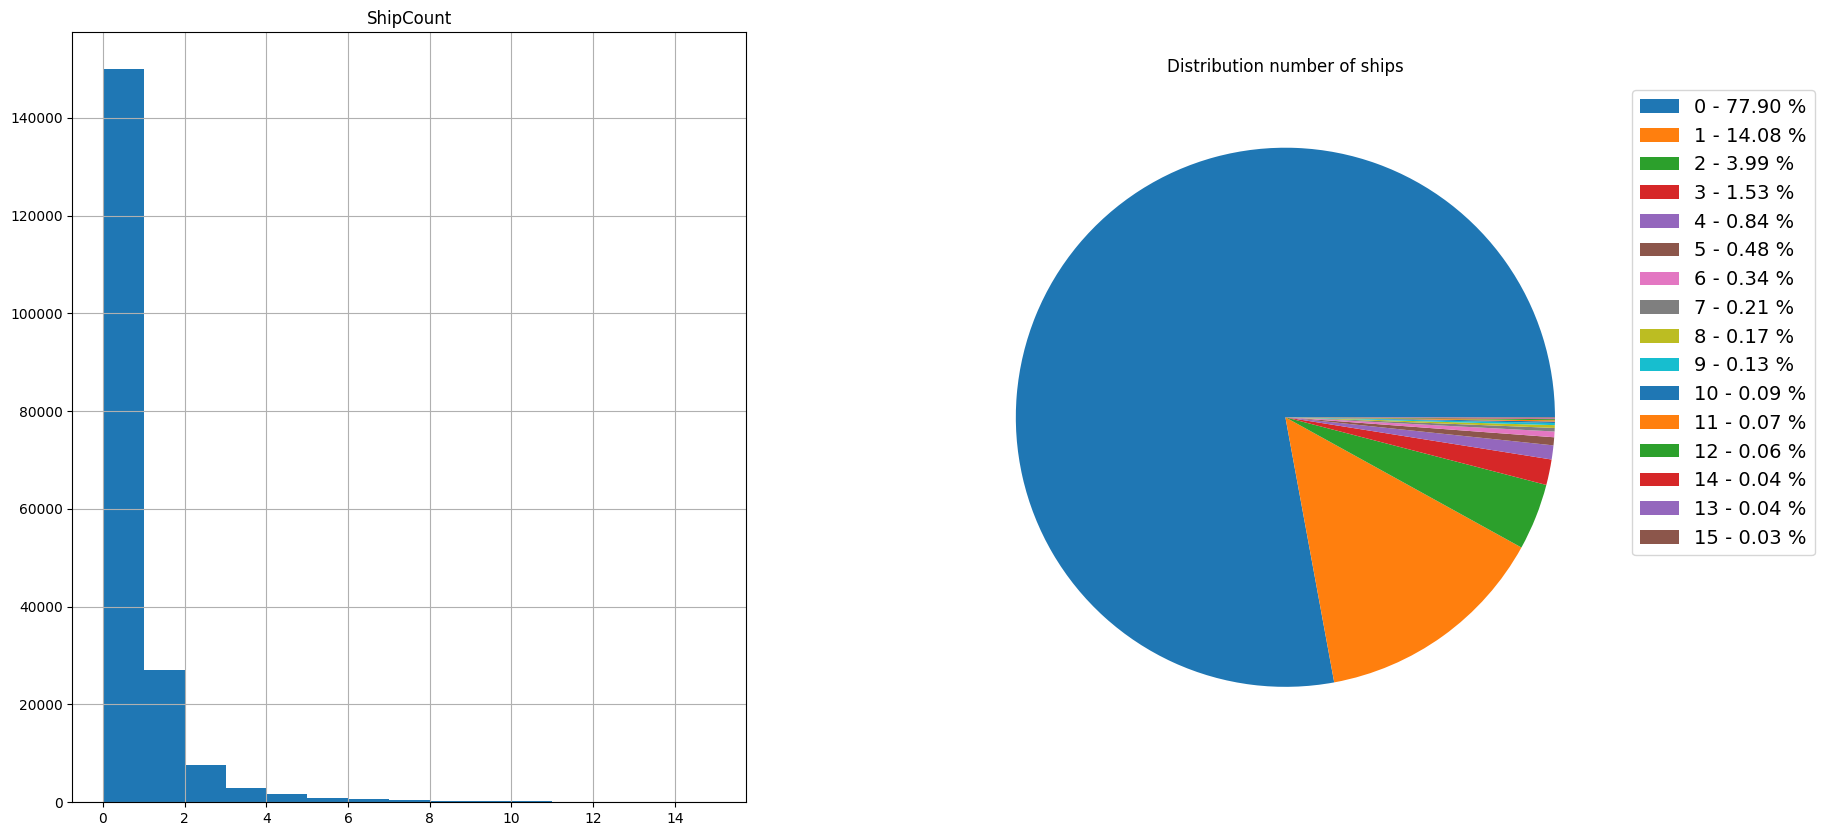

In [299]:
segmentations['ShipCount'] = segmentations.apply(lambda x: 0 if pd.isna(x['EncodedPixels']) else 1, axis=1)
ships_numbers = segmentations[['ImageId','ShipCount']].groupby(['ImageId']).sum()
print(ships_numbers.value_counts())

f,ax=plt.subplots(1, 2,figsize=(20,10))

ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

We can see that 78% of images don't have any ships. Only 14% have one ship. And on the remaining 8% of the images there are from 2 to 15 ships.

## Ship segmentation area distribution

Text(0.5, 0, '')

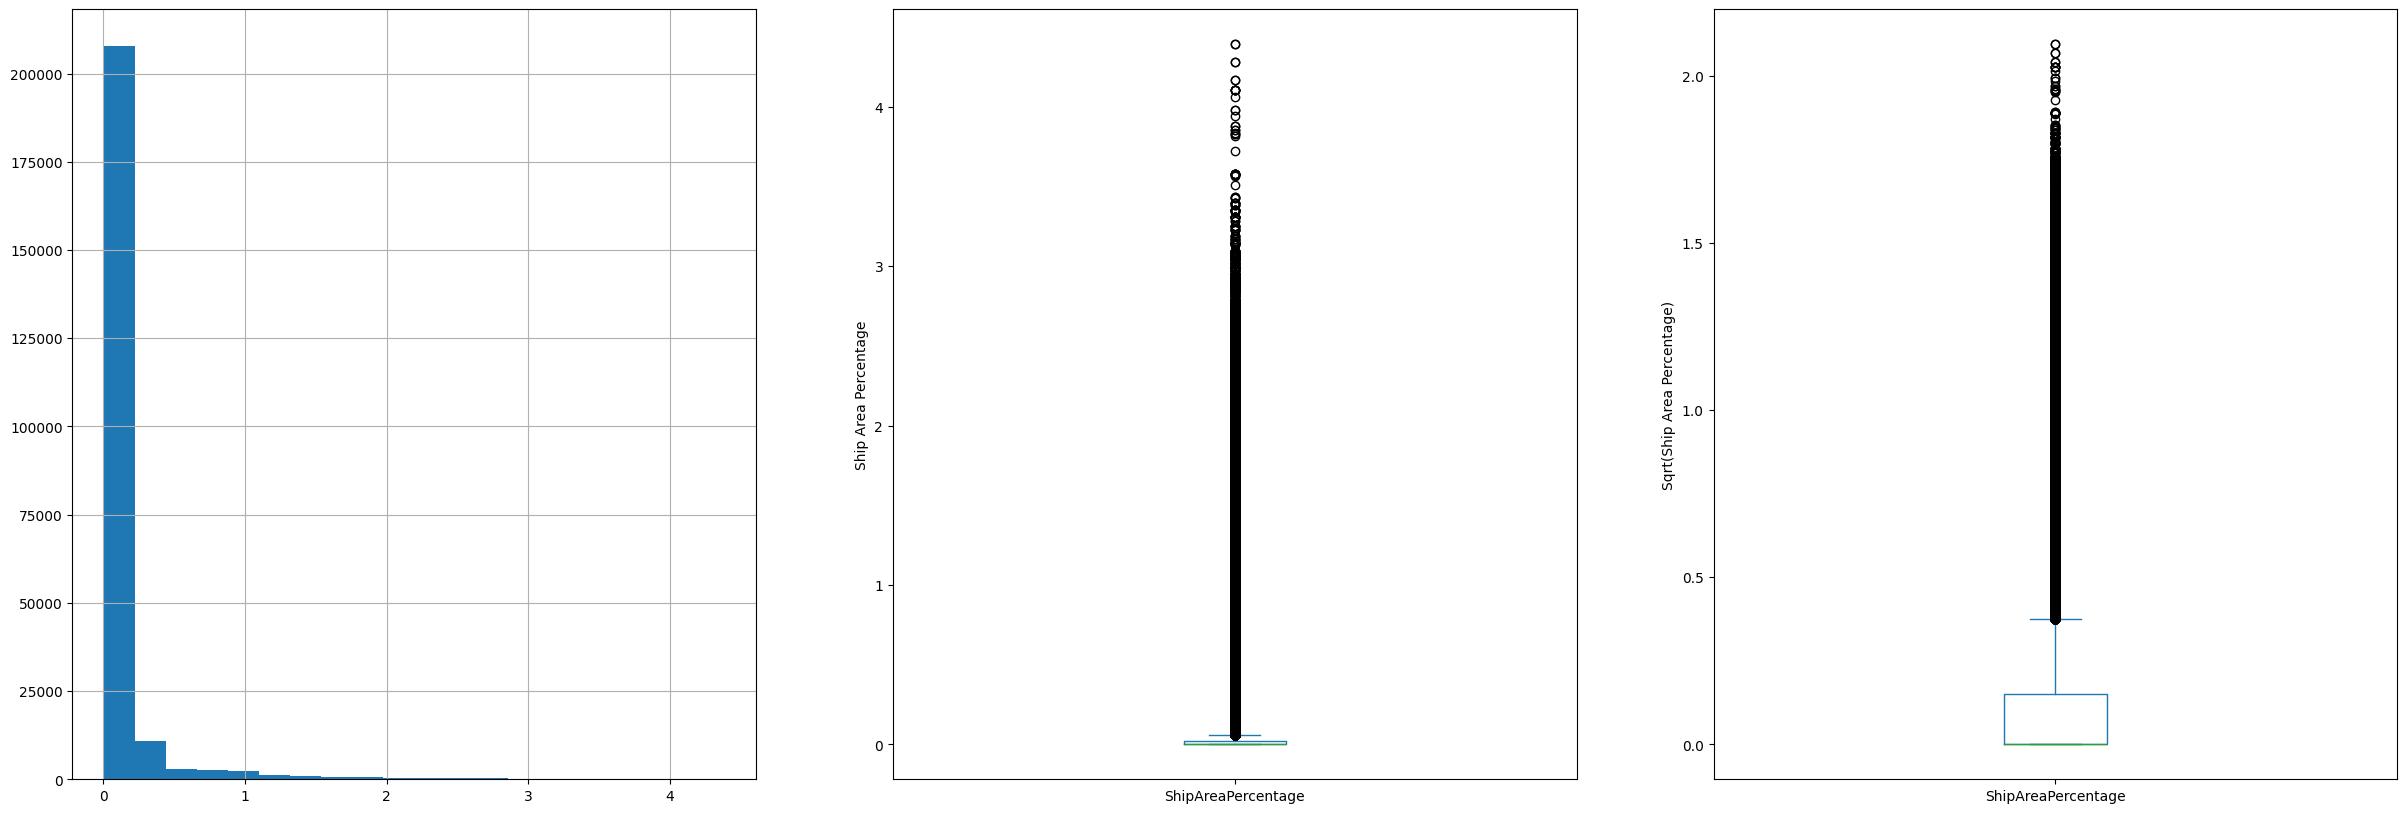

In [300]:
f,ax=plt.subplots(1, 3,figsize=(30,10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
segmentations['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('')

All ships are very small in the images. Ships occupy no more than 4% of the image. Most of the ships take up less than 0.1% of the image.

## Display ship segmentation pixels

In [301]:
def show_image_with_encoded_pixels(image_id: str):
    rows = segmentations[segmentations['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    ax_rows_number = ship_count + 1
    f,ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))
        
    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()

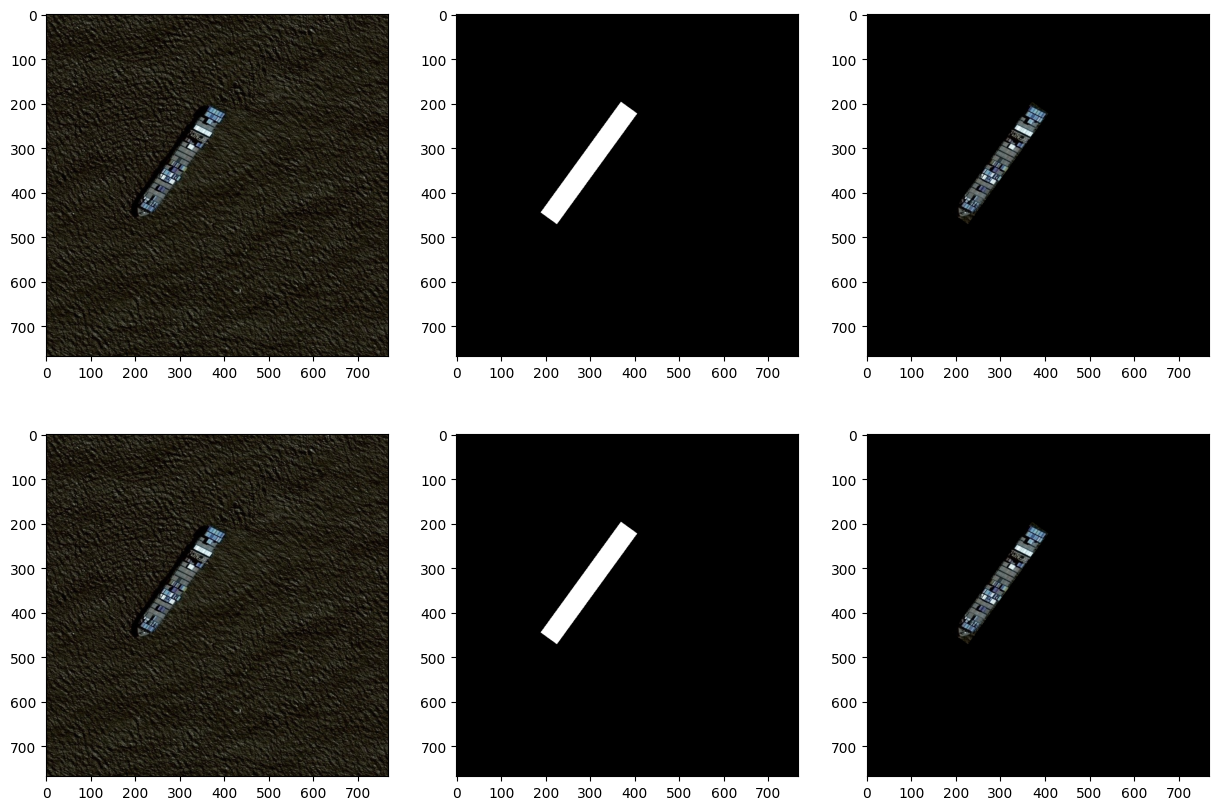

ImageId                                      EncodedPixels  \
32  0006c52e8.jpg  146366 1 147132 4 147899 5 148666 7 149432 10 ...   

    ImageHeight  ImageWidth  ShipAreaPercentage  ShipCount  
32          768         768            2.355448          1

In [302]:
image_id = '0006c52e8.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

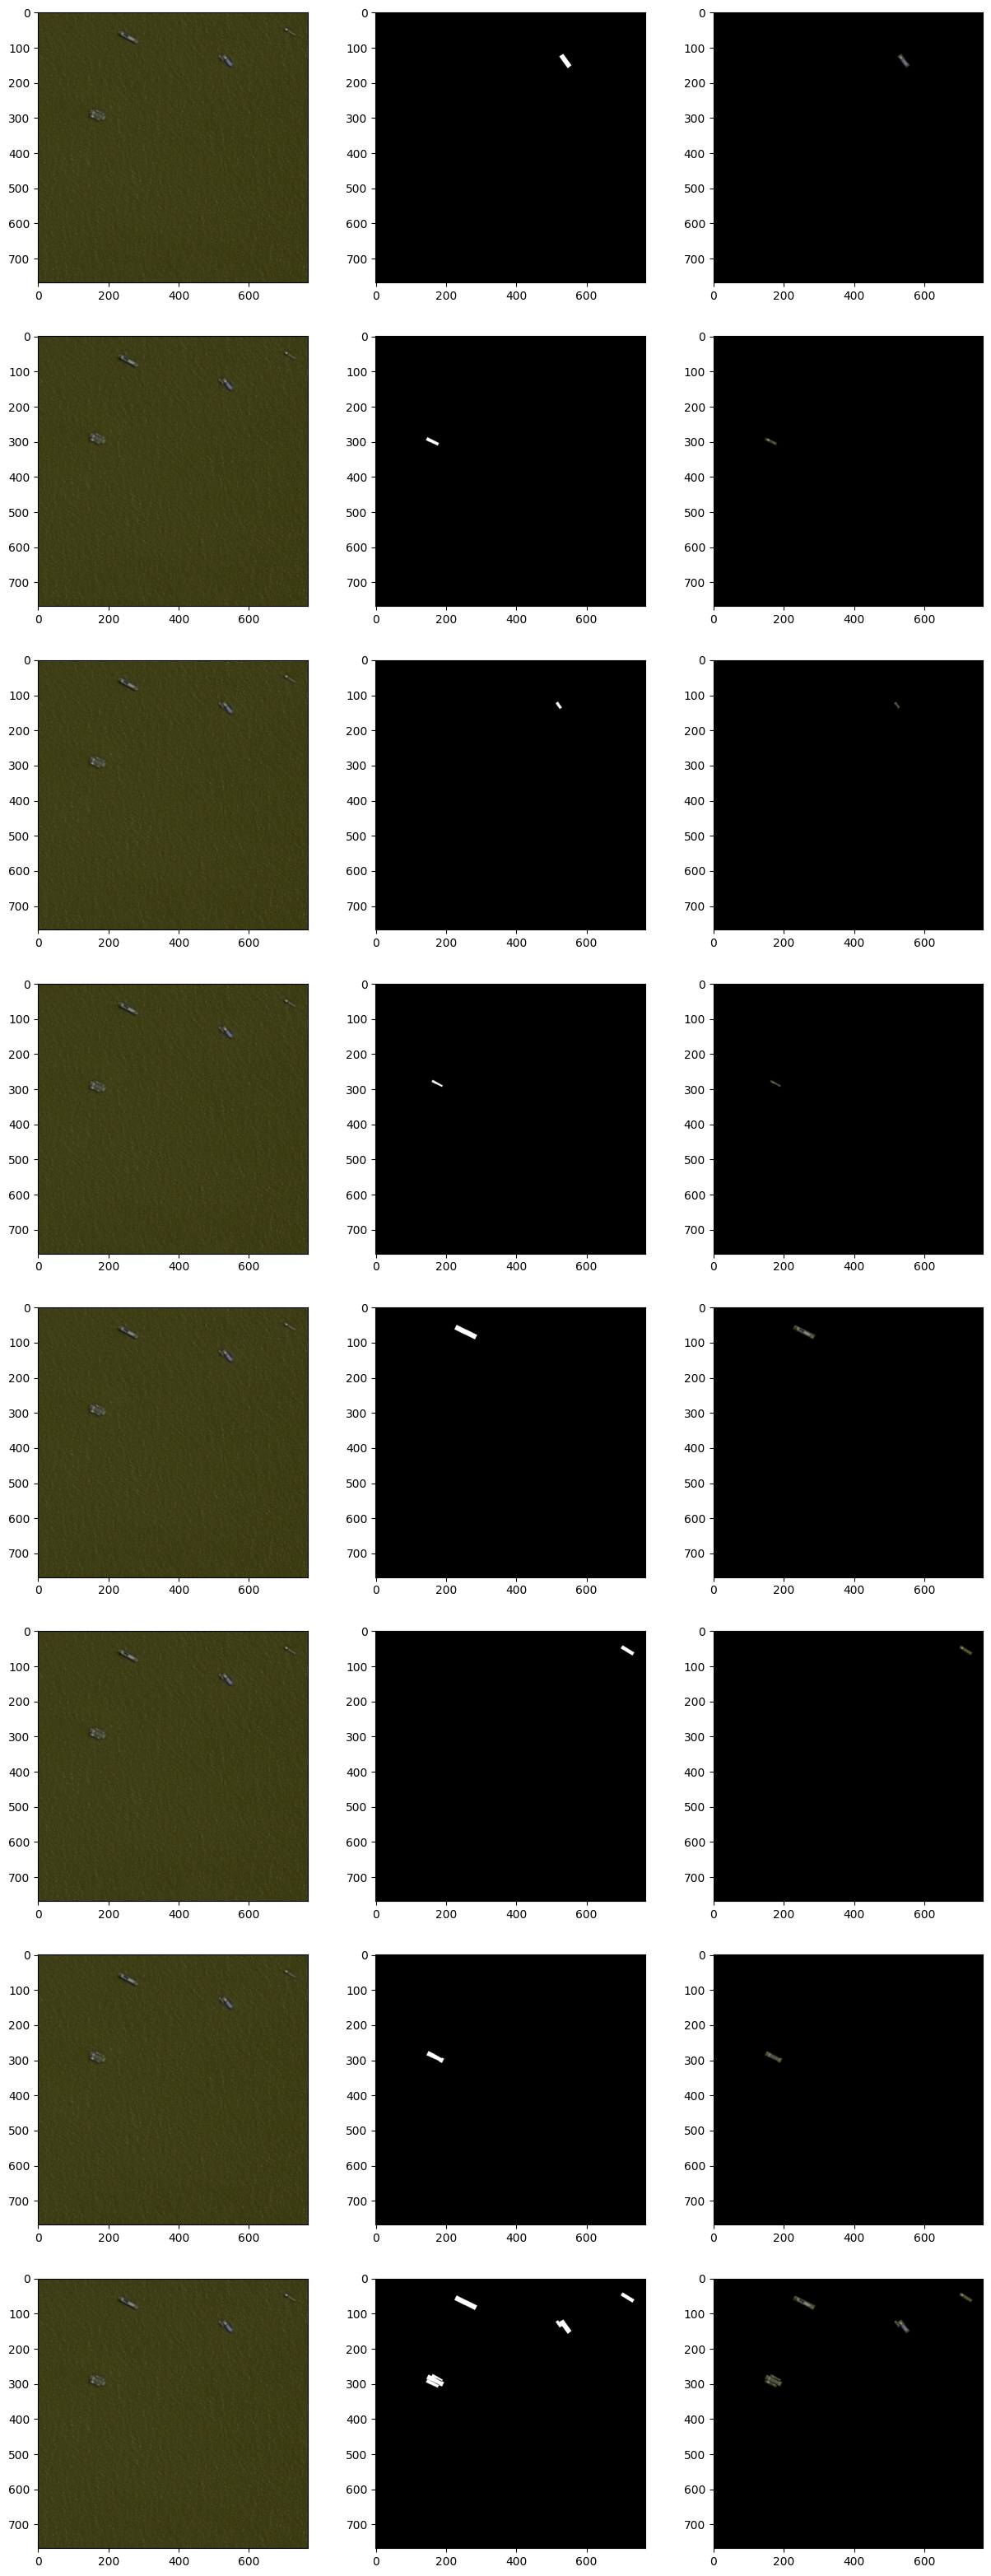

ImageId                                      EncodedPixels  \
60  00113a75c.jpg  401790 1 402557 3 403325 5 404092 7 404859 9 4...   
61  00113a75c.jpg  110888 2 111654 4 112420 7 113186 9 113953 11 ...   
62  00113a75c.jpg  394109 1 394876 4 395644 5 396411 8 397178 10 ...   
63  00113a75c.jpg  123159 1 123925 4 124691 6 125458 8 126227 7 1...   
64  00113a75c.jpg  172862 2 173628 4 174394 7 175160 9 175926 12 ...   
65  00113a75c.jpg  536114 1 536880 4 537646 6 538413 8 539179 10 ...   
66  00113a75c.jpg  111647 1 112413 3 113179 6 113945 8 114711 10 ...   

    ImageHeight  ImageWidth  ShipAreaPercentage  ShipCount  
60          768         768            0.094774          1  
61          768         768            0.056458          1  
62          768         768            0.027296          1  
63          768         768            0.032383          1  
64          768         768            0.158522          1  
65          768         768            0.068834          1  
66          768         768            0.104099          1

In [303]:
image_id = '00113a75c.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

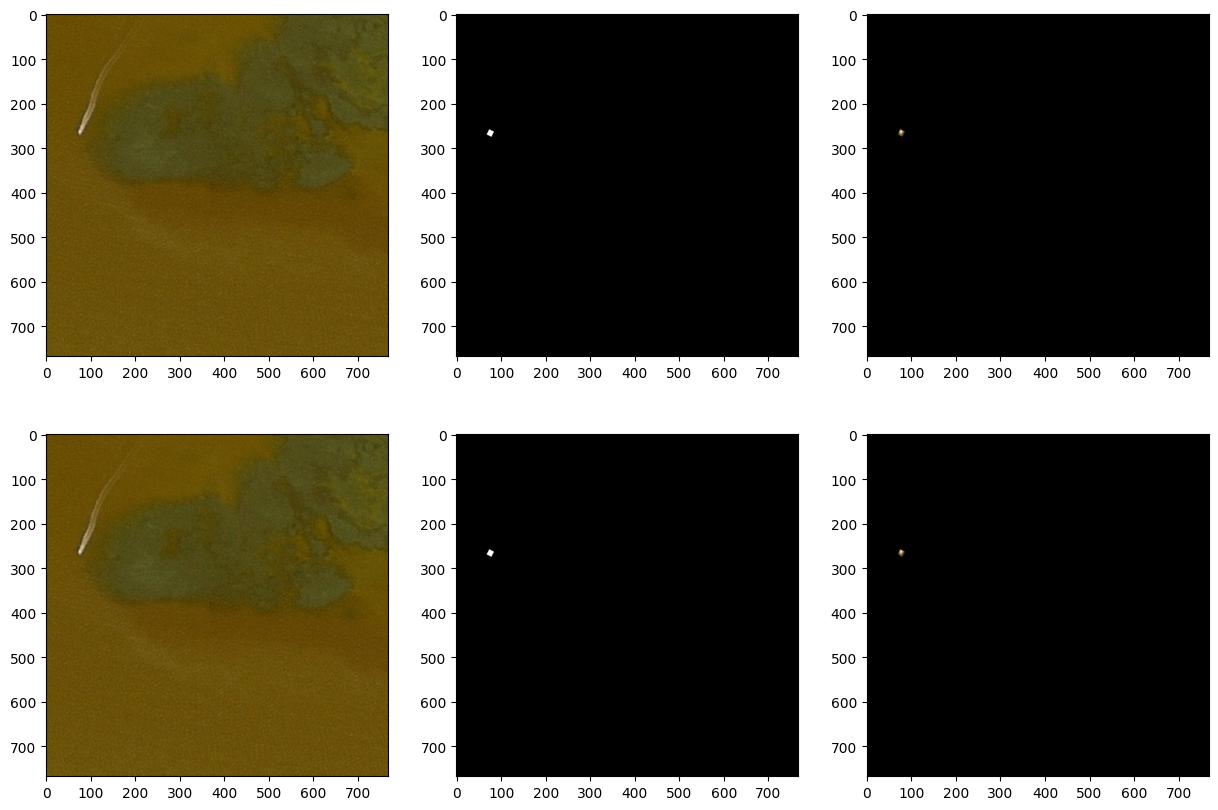

ImageId                                      EncodedPixels  \
56  000fd9827.jpg  53262 2 54028 4 54794 7 55560 9 56326 12 57092...   

    ImageHeight  ImageWidth  ShipAreaPercentage  ShipCount  
56          768         768            0.026618          1

In [304]:
image_id = '000fd9827.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

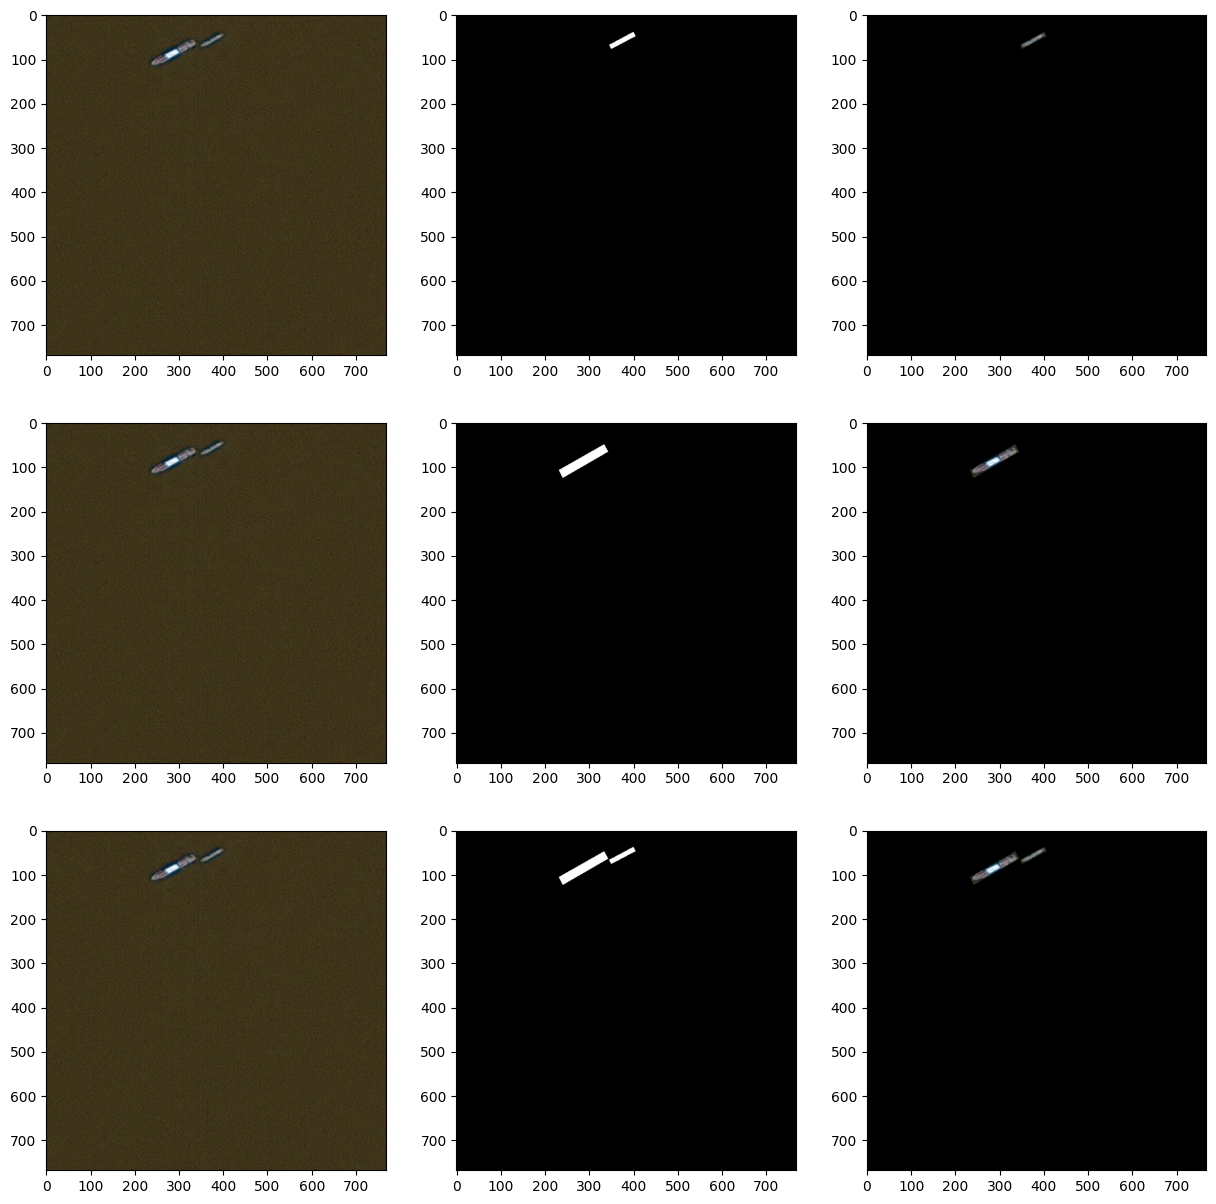

ImageId                                      EncodedPixels  \
383  007534159.jpg  265796 2 266563 5 267331 7 268098 10 268866 12...   
384  007534159.jpg  178283 1 179050 4 179818 6 180585 9 181353 11 ...   

     ImageHeight  ImageWidth  ShipAreaPercentage  ShipCount  
383          768         768            0.116136          1  
384          768         768            0.394864          1

In [305]:
image_id = '007534159.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

## Data analysis results

It was found that most of the images (78%) do not contain ships.
All the ships in the images take up a very small part (approximately 0,1%), the pictures contain a lot of background.
Also, target segmentation for labeled pictures consists of bounding boxes (rectangles). Ships do not intersect, but their borders in some images have adjacent borders.

# Train Unet Model

In [306]:
import random
import os
import tensorflow as tf
from tensorflow import keras

# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

TRAIN_DIR = 'airbus-ship-detection/train_v2/'
TEST_DIR = 'airbus-ship-detection/test_v2/'

In [307]:
df = pd.read_csv("airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
CORRUPTED_IMAGES = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

## Utils

In [308]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = img.astype('float32')
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = np.stack(np.vectorize(lambda x: 0 if x < 0.1 else 1)(img), axis=1)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Data preprocessing

In [309]:
IMAGES_WITHOUT_SHIPS_NUMBER = 10000

# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images = list(filter(lambda x: x not in CORRUPTED_IMAGES, images_list))

In [310]:
VALIDATION_LENGTH = 20000
TEST_LENGTH = 2000
TRAIN_LENGTH = len(images) - VALIDATION_LENGTH
BATCH_SIZE = 16
BUFFER_SIZE = 1000
IMG_SHAPE = (256, 256)
NUM_CLASSES = 2

In [311]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

In [312]:
def train_generator(images, dir=TRAIN_DIR):
    for img in images:
        # Load image
        img_path = os.path.join(dir, img)
        img_path = img_path.decode('utf-8')
        image = cv2.imread(img_path)
        input_image = cv2.resize(image, IMG_SHAPE)
        input_image = tf.cast(input_image, tf.float32) / 255.0

        encoded_mask = image_segmentation[image_segmentation['ImageId'] == img.decode('utf-8')].iloc[0]['EncodedPixels']
        input_mask = np.zeros(IMG_SHAPE + (1,), dtype=np.int8)
        if not pd.isna(encoded_mask):
            input_mask = rle_to_mask(encoded_mask)  
            input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
            input_mask = np.expand_dims(input_mask, axis=2)
        one_hot_segmentation_mask = one_hot(input_mask, NUM_CLASSES)
        input_mask_tensor = tf.convert_to_tensor(one_hot_segmentation_mask, dtype=tf.float32)

        yield input_image, input_mask_tensor

In [313]:
dataset = tf.data.Dataset.from_generator(train_generator, args=[images, TRAIN_DIR], output_types=(tf.float32, tf.float32), output_shapes=((256, 256, 3), (256, 256, 2)))

dataset = dataset.shuffle(BUFFER_SIZE)

validation_dataset = dataset.take(VALIDATION_LENGTH).batch(BATCH_SIZE).repeat()
train_dataset = dataset.skip(VALIDATION_LENGTH).batch(BATCH_SIZE).repeat()

## UNet segmentation model

The UNet network was chosen as the architecture of the neural network for semantic segmentation, which allows high-precision segmentation of images, highlighting all the ships in the image.
For better accuracy and fewer model parameters, we use a MobileNetV2 classification model with trained weights as an encoder.


In [314]:
import keras.backend as K
import tensorflow_addons as tfa

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape, num_classes=NUM_CLASSES) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)
        
        filters_list = [16, 32, 64]

        # apply Encoder
        encoder_outputs = self._encoder(input_shape, filters_list)(inputs)
        print(f'Encoder output tensors: {encoder_outputs}')

        # apply Decoder and establishing the skip connections
        x = self._decoder(encoder_outputs, filters_list[::-1])

        # This is the last layers of the model
        last = self._conv_blocks(num_classes, size=1)(x)
        outputs = tf.keras.activations.softmax(last)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape, filters_list):
        inputs = tf.keras.layers.Input(shape=input_shape)
        outputs = []

        model = tf.keras.Sequential()
        x = model(inputs)

        for filters in filters_list:
            x = self._conv_blocks(filters=filters, size=3, apply_instance_norm=True)(x)
            x = self._conv_blocks(filters=filters, size=1, apply_instance_norm=True)(x)
            outputs.append(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

        output = self._conv_blocks(filters=128, size=3, apply_batch_norm=True, apply_dropout=False)(x)
        outputs.append(output)

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name="encoder")
        encoder.trainable = True
        return encoder
    
    def _decoder(self, encoder_outputs, filters_list):     
        x = encoder_outputs[-1]
        for filters, skip, apply_dropout in zip(filters_list, encoder_outputs[-2::-1], [False] * 4):
            x = self._upsample_block(filters, 3)(x)
            x = tf.keras.layers.Concatenate()([x, skip])
            x = self._conv_blocks(filters, size=3, apply_batch_norm=True, apply_dropout=apply_dropout)(x)
            x = self._conv_blocks(filters, size=1, apply_batch_norm=True)(x)
        return x
    
    def _conv_blocks(self, filters, size, apply_batch_norm=False, apply_instance_norm=False, apply_dropout=False):
        """Downsamples an input. Conv2D => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Downsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2D(filters, size, strides=1,
                                 padding='same', use_bias=False,
                                 kernel_initializer=initializer,))
        if apply_batch_norm:
            result.add(tf.keras.layers.BatchNormalization())
        if apply_instance_norm:
            result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.55))
        return result
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        return result

In [315]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.confusion_matrix = self.add_weight(name='confusion_matrix', shape=(2, 2), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.math.round(tf.reshape(y_pred, [-1])), tf.float32)

        # Flatten the predictions and true labels to 1D arrays
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Compute confusion matrix
        confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2, dtype=tf.float32)

        # Update state
        self.confusion_matrix.assign_add(confusion_matrix)

    def result(self):
        true_positives = self.confusion_matrix[1, 1]
        false_negatives = self.confusion_matrix[1, 0]
        false_positives = self.confusion_matrix[0, 1]

        intersection = true_positives
        union = true_positives + false_negatives + false_positives

        iou = intersection / (union + tf.keras.backend.epsilon())
        return iou

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = {
            "confusion_matrix": self.confusion_matrix
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [316]:
class DiceScore(tf.keras.metrics.Metric):
    def __init__(self, name='dice_score', **kwargs):
        super(DiceScore, self).__init__(name=name, **kwargs)
        self.confusion_matrix = self.add_weight(name='confusion_matrix', shape=(2, 2), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.math.round(tf.reshape(y_pred, [-1])), tf.float32)

        # Flatten the predictions and true labels to 1D arrays
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Compute confusion matrix
        confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2, dtype=tf.float32)

        # Update state
        self.confusion_matrix.assign_add(confusion_matrix)

    def result(self):
        true_positives = self.confusion_matrix[1, 1]
        false_negatives = self.confusion_matrix[1, 0]
        false_positives = self.confusion_matrix[0, 1]

        dice_score = 2.0 * true_positives / (2.0 * true_positives + false_negatives + false_positives + tf.keras.backend.epsilon())
        return dice_score

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = {
            "confusion_matrix": self.confusion_matrix
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

Encoder output tensors: [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'encoder')>]
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 256, 256, 1  103536      ['input_9[0][0]']                
                       

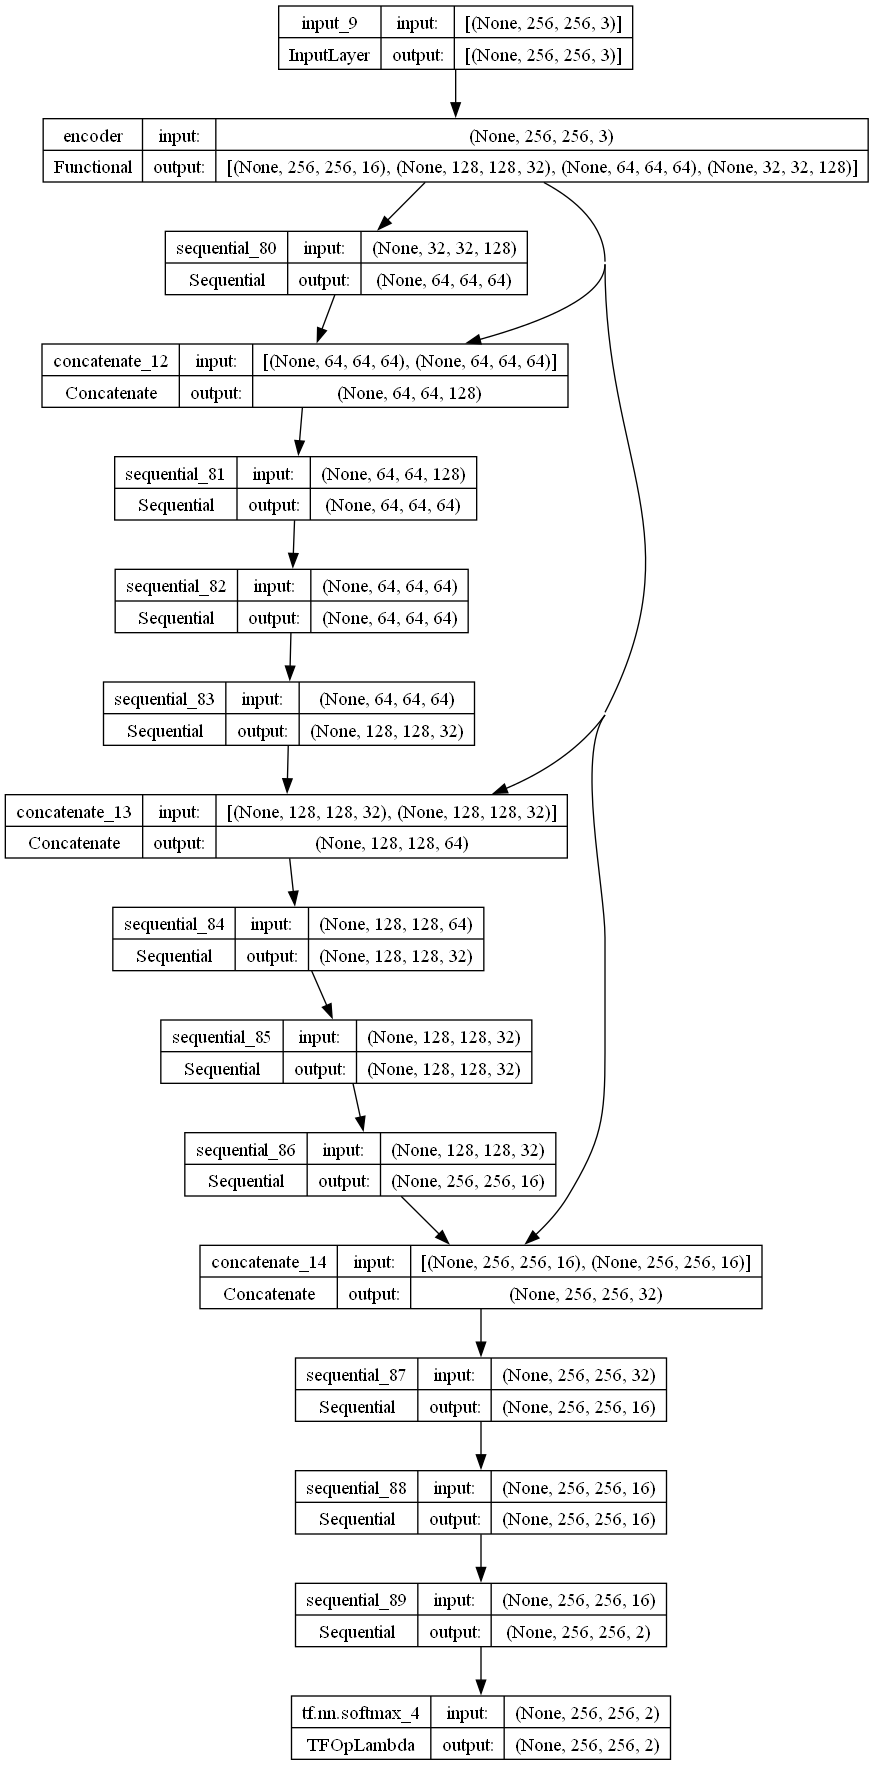

In [317]:
EPOCHS = 3
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

loss = tf.keras.losses.CategoricalCrossentropy()
dice = DiceScore()
iou = IoU()

model = UNetModel(IMG_SHAPE + (3,)).model
model.compile(optimizer='adam', 
              loss=loss, # bce_dice_loss,
              metrics=[dice, iou,],)

model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_dataset
                          )

model.save('saved_model/my_model')

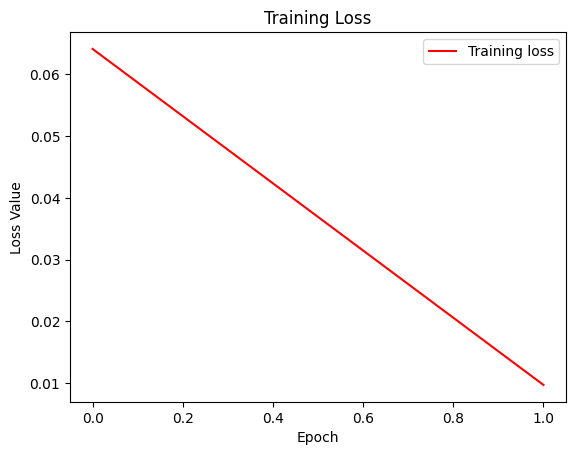

In [ ]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'C2', label='Validation loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

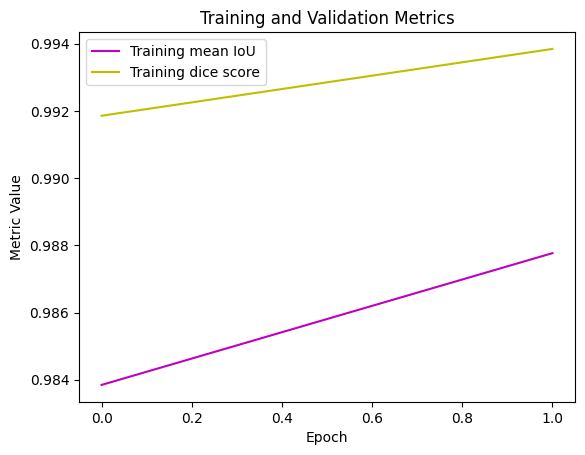

In [ ]:
iou = model_history.history['iou']
dice_score = model_history.history['dice_score']

plt.figure()
plt.plot(model_history.epoch, iou, 'm', label='Training mean IoU')
plt.plot(model_history.epoch, dice_score, 'y', label='Training dice score')

plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)  
    return pred_mask

# Deep Watershed Transform

# Results analysis

1/1 [==============================] - 0s 17ms/step


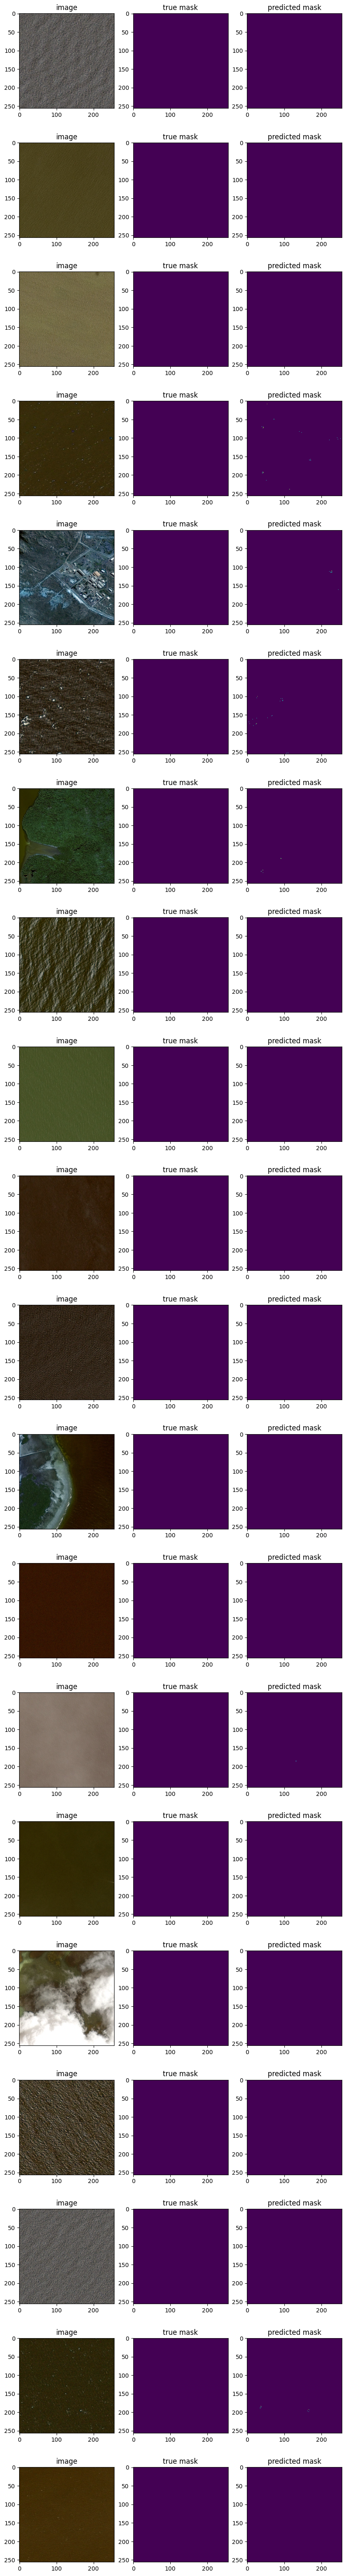

In [ ]:
N = 10

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))

for i in range(N):
    image, mask = next(iter(validation_dataset.unbatch()))
    mask = mask.numpy().argmax(axis=-1)
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('true mask')

    pred_mask = predict(image)
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('predicted mask')

plt.show()

It is rather hard to find examples that contain ship :( 

In [ ]:
def test_generator(images, dir=TEST_DIR):
    # Generate batches
    for image in images:
        img_path = os.path.join(dir, image)
        img_path = img_path.decode('utf-8')
        image = cv2.imread(img_path)
        input_image = cv2.resize(image, IMG_SHAPE)
        input_image = tf.cast(input_image, tf.float32) / 255.0

        yield input_image

In [ ]:
test_images = os.listdir(TEST_DIR)
test_dataset = tf.data.Dataset.from_generator(test_generator, args=[test_images, TEST_DIR], output_types=tf.float32)

In [ ]:
results = model.evaluate(validation_dataset)
print("test loss, test mIoU:", results)

1250/1250 [==============================] - 629s 488ms/step - loss: 0.0062 - dice_score: 0.9974 - iou: 0.9948
test loss, test mIoU: [0.0062194159254431725, 0.9973782896995544, 0.9947701692581177]


# Submission

In [ ]:
submission = pd.read_csv("airbus-ship-detection/sample_submission_v2.csv")

def set_model_prediction(row: pd.Series) -> pd.Series:
    image = cv2.imread(f'{TEST_DIR}{row["ImageId"]}')
    image = cv2.resize(image, IMG_SHAPE, interpolation=cv2.INTER_AREA)
    image = image / 255.0
    pred_mask = predict(image)
    row['EncodedPixels'] = mask_to_rle(pred_mask)
    if row['EncodedPixels'] == '':
        row['EncodedPixels'] = np.nan
    return row

submission = submission.apply(lambda x: set_model_prediction(x), axis=1).set_index("ImageId")

submission.to_csv("./submission.csv")
submission

1/1 [==============================] - 0s 21ms/step


EncodedPixels
ImageId                                                         
00002bd58.jpg                                                NaN
00015efb6.jpg                                                NaN
00023d5fc.jpg                                                NaN
000367c13.jpg  99571 3 100339 3 101107 3 101857 3 102625 3 10...
0008ca6e9.jpg                                                NaN
...                                                          ...
ffdb3cda6.jpg  32419 3 33187 3 33955 3 306934 3 307702 3 3084...
ffe3857eb.jpg                                                NaN
ffeb765e8.jpg  205357 3 206125 3 206893 3 221467 3 221494 3 2...
ffeba1475.jpg  9889 3 9895 6 10657 3 10663 6 11425 3 11431 6 ...
fff0fd44f.jpg                                                NaN

[15606 rows x 1 columns]

# How can we try to improve the model

1. Pretrain the encoder for classifying ships. And then do not change the encoder weights when training the segmentation model.
2. Use Data Augmentation for images with ships
3. Reduce the number of images without ships when training the model
4. Use original image shape (`768 * 768 * 3`) when training model